In [1]:
# Import necessary modules and set global constants and variables. 
      
import pandas as pd                 
import numpy as np                                       
from sklearn.cluster import KMeans
from scipy.ndimage.morphology import binary_fill_holes
import cv2                         # To read and manipulate images
import os                          # For filepath, directory handling
import sys                         # System-specific parameters and functions
import tqdm                        # Use smart progress meter
import seaborn as sns              # For pairplots
import matplotlib.pyplot as plt    # Python 2D plotting library
import matplotlib.cm as cm         # Color map
%matplotlib inline 

In [2]:
# Global constants.
TRAIN_DIR = '../input/stage1_train'
TEST_DIR = '../input/stage1_test'
IMG_DIR_NAME = 'images'   # Folder name including the image
MASK_DIR_NAME = 'masks'   # Folder name including the masks
    

# Display working/train/test directories.
print('TRAIN_DIR = {}'.format(TRAIN_DIR))
print('TEST_DIR = {}'.format(TEST_DIR))

TRAIN_DIR = ../input/stage1_train
TEST_DIR = ../input/stage1_test


In [5]:
# Collection of methods for data operations. Implemented are functions to read  
# images/masks from files and to read basic properties of the train/test data sets.
# https://www.kaggle.com/bonlime/train-test-image-mosaic

def read_image(filepath, color_mode=cv2.IMREAD_COLOR, target_size=None,space='bgr'):
    """Read an image from a file and resize it."""
    img = cv2.imread(filepath, color_mode)
    if target_size: 
        img = cv2.resize(img, target_size, interpolation = cv2.INTER_AREA)
    if space == 'hsv':
        img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    return img

def read_train_data_properties(train_dir, img_dir_name, mask_dir_name):
    """Read basic properties of training images and masks"""
    tmp = []
    for i,dir_name in enumerate(next(os.walk(train_dir))[1]):

        img_dir = os.path.join(train_dir, dir_name, img_dir_name)
        mask_dir = os.path.join(train_dir, dir_name, mask_dir_name) 
        num_masks = len(next(os.walk(mask_dir))[2])
        img_name = next(os.walk(img_dir))[2][0]
        img_name_id = os.path.splitext(img_name)[0]
        img_path = os.path.join(img_dir, img_name)
#         mask_path = os.path.join(train_dir,dir_name,FULL_MASK_DIR_NAME,img_name_id+'_mask.png')
        mask_path = os.path.join(train_dir,dir_name,MASK_DIR_NAME,img_name_id+'_mask.png')

        img_shape = read_image(img_path).shape
        tmp.append(['{}'.format(img_name_id), img_shape[0], img_shape[1],
                    img_shape[0]/img_shape[1], img_shape[2], num_masks,
                    img_path, mask_dir,mask_path])

    train_df = pd.DataFrame(tmp, columns = ['img_id', 'img_height', 'img_width',
                                            'img_ratio', 'num_channels', 
                                            'num_masks', 'image_path', 'mask_dir','mask_path'])
    return train_df


def read_test_data_properties(test_dir, img_dir_name):
    """Read basic properties of test images."""
    tmp = []
    for i,dir_name in enumerate(next(os.walk(test_dir))[1]):

        img_dir = os.path.join(test_dir, dir_name, img_dir_name)
        img_name = next(os.walk(img_dir))[2][0]
        img_name_id = os.path.splitext(img_name)[0]
        img_path = os.path.join(img_dir, img_name)
        img_shape = read_image(img_path).shape
        tmp.append(['{}'.format(img_name_id), img_shape[0], img_shape[1],
                    img_shape[0]/img_shape[1], img_shape[2], img_path])

    test_df = pd.DataFrame(tmp, columns = ['img_id', 'img_height', 'img_width',
                                           'img_ratio', 'num_channels', 'image_path'])
    return test_df

def load_raw_data(image_size=(256, 256), space = 'bgr',load_mask=True):
    """Load raw data."""
    # Python lists to store the training images/masks and test images.
    x_train, y_train, x_test = [],[],[]

    # Read and resize train images/masks. 
    print('Loading and resizing train images and masks ...')
    sys.stdout.flush()
    for i, filename in tqdm.tqdm(enumerate(train_df['image_path']), total=len(train_df)):
        img = read_image(train_df['image_path'].loc[i], target_size=image_size,space = space)
        if load_mask:
            mask = read_image(train_df['mask_path'].loc[i],
                              color_mode=cv2.IMREAD_GRAYSCALE,
                              target_size=image_size)
            #mask = read_mask(train_df['mask_dir'].loc[i], target_size=image_size)
            y_train.append(mask)
        x_train.append(img)
        
    # Read and resize test images. 
    print('Loading and resizing test images ...')
    sys.stdout.flush()
    for i, filename in tqdm.tqdm(enumerate(test_df['image_path']), total=len(test_df)):
        img = read_image(test_df['image_path'].loc[i], target_size=image_size,space=space)
        x_test.append(img)

    # Transform lists into 4-dim numpy arrays.
    x_train = np.array(x_train)
    #if load_mask:
    y_train = np.array(y_train)
    #y_train = np.expand_dims(np.array(y_train), axis=4)
    x_test = np.array(x_test)
    print('Data loaded')
    if load_mask:
        return x_train, y_train, x_test
    else:
        return x_train, x_test

def get_domimant_colors(img, top_colors=1):
    """Return dominant image color"""
    img_l = img.reshape((img.shape[0] * img.shape[1], img.shape[2]))
    clt = KMeans(n_clusters = top_colors)
    clt.fit(img_l)
    # grab the number of different clusters and create a histogram
    # based on the number of pixels assigned to each cluster
    numLabels = np.arange(0, len(np.unique(clt.labels_)) + 1)
    (hist, _) = np.histogram(clt.labels_, bins = numLabels)
    # normalize the histogram, such that it sums to one
    hist = hist.astype("float")
    hist /= hist.sum()
    return clt.cluster_centers_, hist

def cluster_images_by_hsv():
    """Clusterization based on hsv colors. Adds 'hsv_cluster' column to tables"""
    print('Loading data')
    x_train_hsv,x_test_hsv = load_raw_data(image_size=None,space='hsv',load_mask=False)
    x_hsv = np.concatenate([x_train_hsv,x_test_hsv])
    print('Calculating dominant hsv for each image')
    dominant_hsv = []
    for img in tqdm.tqdm(x_hsv):
        res1, res2 = get_domimant_colors(img,top_colors=1)
        dominant_hsv.append(res1.squeeze())
    print('Calculating clusters')
    kmeans = KMeans(n_clusters=3).fit(dominant_hsv)
    train_df['HSV_CLUSTER'] = kmeans.predict(dominant_hsv[:len(x_train_hsv)])
    test_df['HSV_CLUSTER'] = kmeans.predict(dominant_hsv[len(x_train_hsv):])
    print('Images clustered')
    return None

def plot_images(selected_images_df,images_rows=4,images_cols=8,plot_figsize=4):
    """Plot image_rows*image_cols of selected images. Used to visualy check clusterization"""
    f, axarr = plt.subplots(images_rows,images_cols,figsize=(plot_figsize*images_cols,images_rows*plot_figsize))
    for row in range(images_rows):
        for col in range(images_cols):
            if (row*images_cols + col) < selected_images_df.shape[0]:
                image_path = selected_images_df['image_path'].iloc[row*images_cols + col]
            else:
                continue
            img = read_image(image_path)
            height, width, l = img.shape
            ax = axarr[row,col]
            ax.axis('off')
            ax.set_title("%dx%d"%(width, height))
            ax.imshow(img)

In [6]:
# Basic properties of images/masks. 
train_df = read_train_data_properties(TRAIN_DIR, IMG_DIR_NAME, MASK_DIR_NAME)
test_df = read_test_data_properties(TEST_DIR, IMG_DIR_NAME)
cluster_images_by_hsv()

df_path = "../input/test-train-df"
if not os.path.isdir(df_path):
    os.mkdir(df_path)
    
train_df.to_csv('../input/test-train-df/train_df.csv',index=False)
test_df.to_csv('../input/test-train-df/test_df.csv',index=False)


Loading data
Loading and resizing train images and masks ...


100%|██████████| 670/670 [00:02<00:00, 314.59it/s]

Loading and resizing test images ...



  0%|          | 0/735 [00:00<?, ?it/s]

Data loaded
Calculating dominant hsv for each image


100%|██████████| 735/735 [07:28<00:00,  1.64it/s]

Calculating clusters
Images clustered


In [9]:
# We don't need to compute everything (especially clusters) every time. simly load them
train_df = pd.read_csv('../input/test-train-df/train_df.csv')
test_df = pd.read_csv('../input/test-train-df/test_df.csv')

# we need to change filepath from my filesystem to kaggle filesystem
train_change_filepath = lambda x: '../input/stage1_train/{0}/images/{0}.png'.format(x.split('/')[-1][:-4])
test_change_filepath = lambda x: '../input/stage1_test/{0}/images/{0}.png'.format(x.split('/')[-1][:-4])
train_df.image_path = train_df.image_path.map(train_change_filepath)
train_df.drop(['mask_dir','mask_path'],inplace=True,axis = 1)
test_df.image_path = test_df.image_path.map(test_change_filepath)

###  training

In [10]:
train_df.head()

,img_id,img_height,img_width,img_ratio,num_channels,num_masks,image_path,HSV_CLUSTER
0,45c3bdef1819ba7029990e159f61543ed25781d13fb4dc...,520,696,0.747126,3,8,../input/stage1_train/45c3bdef1819ba7029990e15...,0
1,7c0157913223365720209ac83ff2e0b1b2b460173acd61...,360,360,1.000000,3,25,../input/stage1_train/7c0157913223365720209ac8...,0
2,d2815f2f616d92be35c7e8dcfe592deec88516aef9ffc9...,256,256,1.000000,3,14,../input/stage1_train/d2815f2f616d92be35c7e8dc...,0
3,76a372bfd3fad3ea30cb163b560e52607a8281f5b04248...,1024,1024,1.000000,3,63,../input/stage1_train/76a372bfd3fad3ea30cb163b...,2
4,3d0ca3498d97edebd28dbc7035eced40baa4af199af09c...,256,256,1.000000,3,4,../input/stage1_train/3d0ca3498d97edebd28dbc70...,0


In [11]:
for idx in range(3):
    print("Images in cluster {}: {}".format(idx,train_df[train_df['HSV_CLUSTER'] == idx].shape[0]))

Images in cluster 0: 546
Images in cluster 1: 108
Images in cluster 2: 16


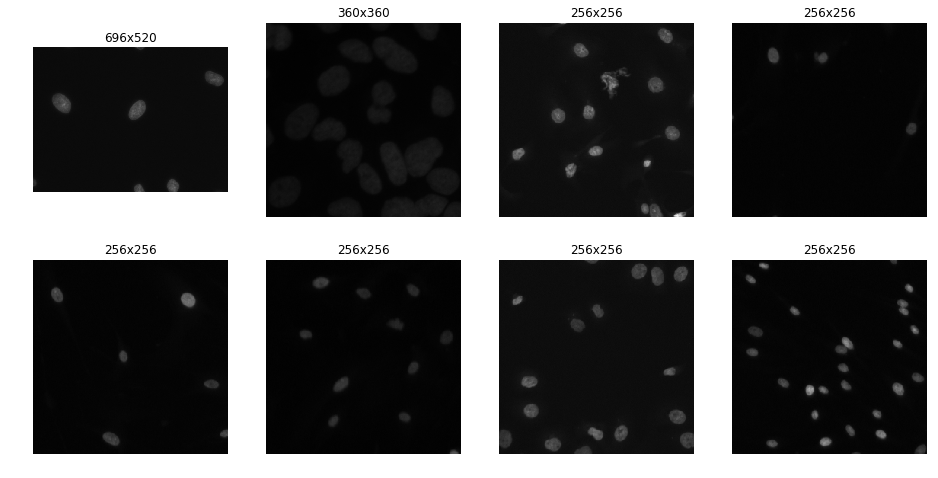

In [12]:
plot_images(train_df[train_df['HSV_CLUSTER'] == 0],2,4)

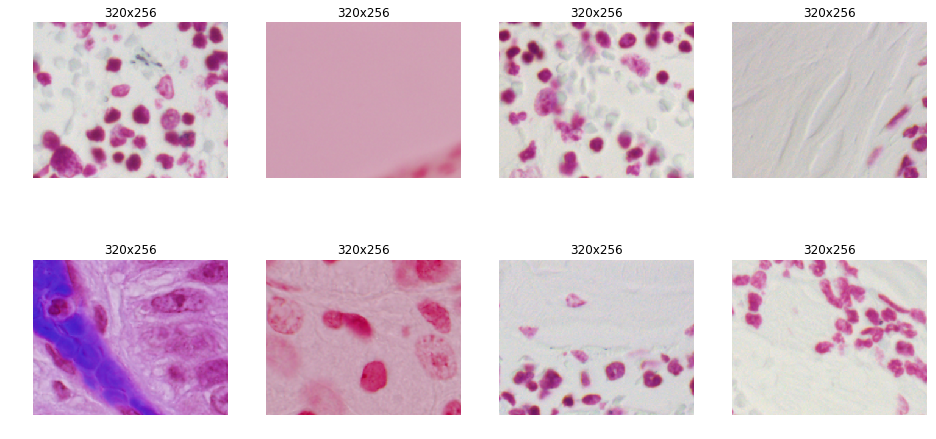

In [13]:
plot_images(train_df[train_df['HSV_CLUSTER'] == 1],2,4)

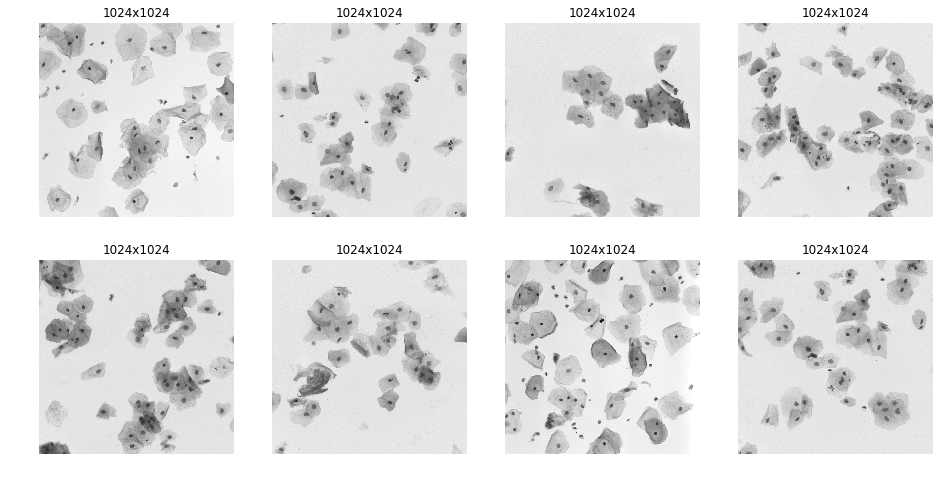

In [14]:
plot_images(train_df[train_df['HSV_CLUSTER'] == 2],2,4)

###  testing

In [15]:
for idx in range(3):
    print("Images in cluster {}: {}".format(idx,test_df[test_df['HSV_CLUSTER'] == idx].shape[0]))

Images in cluster 0: 53
Images in cluster 1: 4
Images in cluster 2: 8


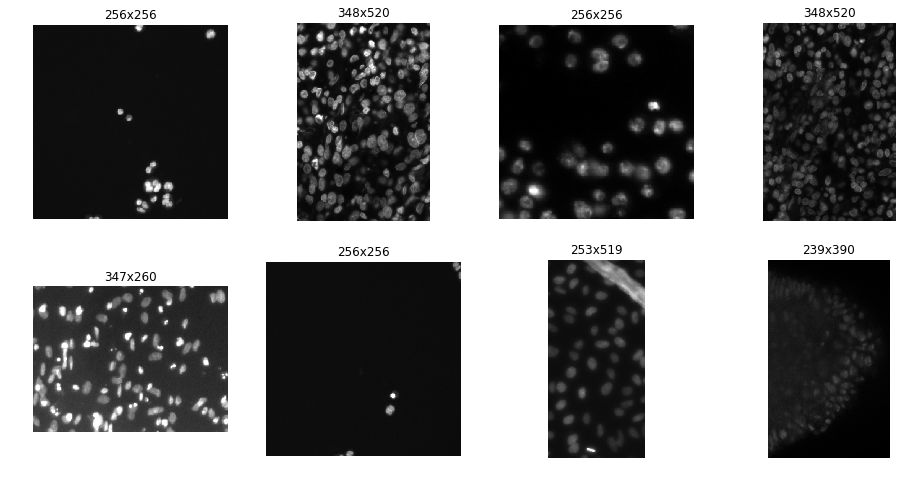

In [16]:
plot_images(test_df[test_df['HSV_CLUSTER'] == 0],2,4)

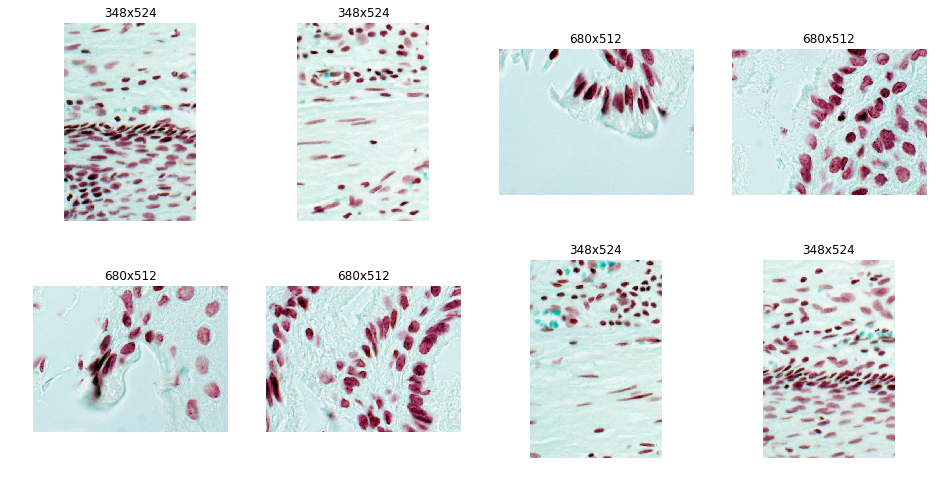

In [17]:
plot_images(test_df[test_df['HSV_CLUSTER'] == 2],2,4)

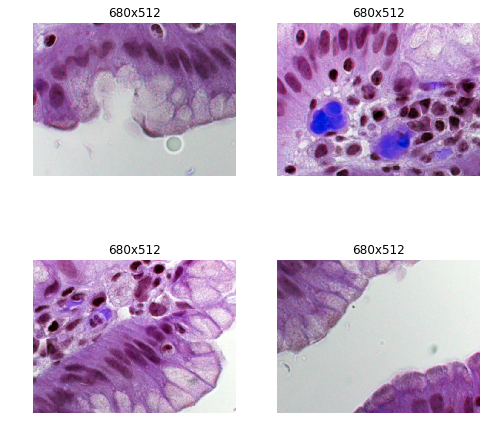

In [21]:
plot_images(test_df[test_df['HSV_CLUSTER'] == 1],2,2)

In [22]:
# Read images/masks from files and resize them. Each image and mask 
# is stored as a 3-dim array where the number of channels is 3 and 1, respectively.
x_train, x_test = load_raw_data(load_mask=False,image_size=None)

Loading and resizing train images and masks ...


100%|██████████| 670/670 [00:01<00:00, 415.11it/s]

Loading and resizing test images ...



100%|██████████| 65/65 [00:00<00:00, 320.45it/s]

Data loaded


In [23]:
x_train.shape

(670,)

### Mosaic

In [24]:
from sklearn.neighbors import NearestNeighbors
# nn == Nearest Neighbors in the comments

In [25]:
def combine_images(data,indexes):
    """ Combines img from data using indexes as follows:
        0 1
        2 3 
    """
    up = np.hstack([data[indexes[0]],data[indexes[1]]])
    down = np.hstack([data[indexes[2]],data[indexes[3]]])
    full = np.vstack([up,down])
    return full

def make_mosaic(data,return_connectivity = False, plot_images = False,external_df = None):
    """Find images with simular borders and combine them to one big image"""
    if external_df is not None:
        external_df['mosaic_idx'] = np.nan
        external_df['mosaic_position'] = np.nan
        # print(external_df.head())
    
    # extract borders from images
    borders = []
    for x in data:
        borders.extend([x[0,:,:].flatten(),x[-1,:,:].flatten(),
                        x[:,0,:].flatten(),x[:,-1,:].flatten()])
    borders = np.array(borders)

    # prepare df with all data
    lens = np.array([len(border) for border in borders])
    img_idx = list(range(len(data)))*4
    img_idx.sort()
    position = ['up','down','left','right']*len(data)
    nn = [None]*len(position)
    df = pd.DataFrame(data=np.vstack([img_idx,position,borders,lens,nn]).T,
                      columns=['img_idx','position','border','len','nn'])
    uniq_lens = df['len'].unique()
    
    for idx,l in enumerate(uniq_lens):
        # fit NN on borders of certain size with 1 neighbor
        nn = NearestNeighbors(n_neighbors=1).fit(np.stack(df[df.len == l]['border'].values))
        distances, neighbors = nn.kneighbors()
        real_neighbor = np.array([None]*len(neighbors))
        distances, neighbors = distances.flatten(),neighbors.flatten()

        # if many borders are close to one, we want to take only the closest
        uniq_neighbors = np.unique(neighbors)

        # difficult to understand but works :c
        for un_n in uniq_neighbors:
            # min distance for borders with same nn
            min_index = list(distances).index(distances[neighbors == un_n].min())
            # check that min is double-sided
            double_sided = distances[neighbors[min_index]] == distances[neighbors == un_n].min()
            if double_sided and distances[neighbors[min_index]] < 1000:
                real_neighbor[min_index] = neighbors[min_index]
                real_neighbor[neighbors[min_index]] = min_index
        indexes = df[df.len == l].index
        for idx2,r_n in enumerate(real_neighbor):
            if r_n is not None:
                df['nn'].iloc[indexes[idx2]] = indexes[r_n]
    
    # img connectivity graph. 
    img_connectivity = {}
    for img in df.img_idx.unique():
        slc = df[df['img_idx'] == img]
        img_nn = {}

        # get near images_id & position
        for nn_border,position in zip(slc[slc['nn'].notnull()]['nn'],
                                      slc[slc['nn'].notnull()]['position']):

            # filter obvious errors when we try to connect bottom of one image to bottom of another
            # my hypotesis is that images were simply cut, without rotation
            if position == df.iloc[nn_border]['position']:
                continue
            img_nn[position] = df.iloc[nn_border]['img_idx']
        img_connectivity[img] = img_nn

    imgs = []
    indexes = set()
    mosaic_idx = 0
    
    # errors in connectivity are filtered 
    good_img_connectivity = {}
    for k,v in img_connectivity.items():
        if v.get('down') is not None:
            if v.get('right') is not None:
                # need down right image
                # check if both right and down image are connected to the same image in the down right corner
                if (img_connectivity[v['right']].get('down') is not None) and img_connectivity[v['down']].get('right') is not None:
                    if img_connectivity[v['right']]['down'] == img_connectivity[v['down']]['right']:
                        v['down_right'] = img_connectivity[v['right']]['down']
                        temp_indexes = [k,v['right'],v['down'],v['down_right']]
                        if (len(np.unique(temp_indexes)) < 4) or (len(indexes.intersection(temp_indexes)) > 0):
                            continue
                        # надо тут фильтровать что они не одинаковые
                        good_img_connectivity[k] = temp_indexes
                        indexes.update(temp_indexes)
                        imgs.append(combine_images(data,temp_indexes))
                        if external_df is not None:
                            external_df['mosaic_idx'].iloc[temp_indexes] = mosaic_idx
                            external_df['mosaic_position'].iloc[temp_indexes] = ['up_left','up_right','down_left','down_right']
                            mosaic_idx += 1
                        continue
            if v.get('left') is not None:
                # need down left image
                if img_connectivity[v['left']].get('down') is not None and img_connectivity[v['down']].get('left') is not None:
                    if img_connectivity[v['left']]['down'] == img_connectivity[v['down']]['left']:
                        v['down_left'] = img_connectivity[v['left']]['down']
                        temp_indexes = [v['left'],k,v['down_left'],v['down']]
                        if (len(np.unique(temp_indexes)) < 4) or (len(indexes.intersection(temp_indexes)) > 0):
                            continue
                        good_img_connectivity[k] = temp_indexes
                        indexes.update(temp_indexes)
                        imgs.append(combine_images(data,temp_indexes))
                        
                        if external_df is not None:
                            external_df['mosaic_idx'].iloc[temp_indexes] = mosaic_idx
                            external_df['mosaic_position'].iloc[temp_indexes] = ['up_left','up_right','down_left','down_right']
                            
                            mosaic_idx += 1 
                        continue
        if v.get('up') is not None:
            if v.get('right') is not None:
                # need up right image
                if img_connectivity[v['right']].get('up') is not None and img_connectivity[v['up']].get('right') is not None:
                    if img_connectivity[v['right']]['up'] == img_connectivity[v['up']]['right']:
                        v['up_right'] = img_connectivity[v['right']]['up']
                        temp_indexes = [v['up'],v['up_right'],k,v['right']]
                        if (len(np.unique(temp_indexes)) < 4) or (len(indexes.intersection(temp_indexes)) > 0):
                            continue
                        good_img_connectivity[k] = temp_indexes
                        indexes.update(temp_indexes)
                        imgs.append(combine_images(data,temp_indexes))
                        
                        if external_df is not None:
                            external_df['mosaic_idx'].iloc[temp_indexes] = mosaic_idx
                            external_df['mosaic_position'].iloc[temp_indexes] = ['up_left','up_right','down_left','down_right']
                            
                            mosaic_idx += 1 
                        continue
            if v.get('left') is not None:
                # need up left image
                if img_connectivity[v['left']].get('up') is not None and img_connectivity[v['up']].get('left') is not None:
                    if img_connectivity[v['left']]['up'] == img_connectivity[v['up']]['left']:
                        v['up_left'] = img_connectivity[v['left']]['up']
                        temp_indexes = [v['up_left'],v['up'],v['left'],k]
                        if (len(np.unique(temp_indexes)) < 4) or (len(indexes.intersection(temp_indexes)) > 0):
                            continue
                        good_img_connectivity[k] = temp_indexes
                        indexes.update(temp_indexes)
                        imgs.append(combine_images(data,temp_indexes))
                        
                        if external_df is not None:
                            external_df['mosaic_idx'].iloc[temp_indexes] = mosaic_idx
                            external_df['mosaic_position'].iloc[temp_indexes] = ['up_left','up_right','down_left','down_right']
                            
                            mosaic_idx += 1 
                        continue

    # same images are present 4 times (one for every piece) so we need to filter them
    print('Images before filtering: {}'.format(np.shape(imgs)))
    
    # can use np. unique only on images of one size, flatten first, then select
    flattened = np.array([i.flatten() for i in imgs])
    uniq_lens = np.unique([i.shape for i in flattened])
    filtered_imgs = []
    for un_l in uniq_lens:
        filtered_imgs.extend(np.unique(np.array([i for i in imgs if i.flatten().shape == un_l]),axis=0))
        
    filtered_imgs = np.array(filtered_imgs)
    print('Images after filtering: {}'.format(np.shape(filtered_imgs)))
    
    if return_connectivity:
        print(good_img_connectivity)
    
    if plot_images:
        for i in filtered_imgs:
            plt.imshow(i)
            plt.show()
            
    # list of not combined images. return if you need
    not_combined = list(set(range(len(data))) - indexes)
    
    if external_df is not None:
        #un_mos_id = external_df[external_df.mosaic_idx.notnull()].mosaic_idx.unique()
        #mos_dict = {k:v for k,v in zip(un_mos_id,range(len(un_mos_id)))}
        #external_df.mosaic_idx = external_df.mosaic_idx.map(mos_dict)
        ## print(temp.mosaic_idx.shape[0])
        ## print(len(temp.mosaic_idx[temp.mosaic_idx.isnull()] ))
        ## print(len(list(range(temp.mosaic_idx.shape[0]-len(temp.mosaic_idx[temp.mosaic_idx.isnull()]),
        ##                     temp.mosaic_idx.shape[0]))))
        external_df.loc[external_df[external_df['mosaic_idx'].isnull()].index,'mosaic_idx'] = range(
            int(np.nanmax(external_df.mosaic_idx.unique())) + 1,
            int(np.nanmax(external_df.mosaic_idx.unique())) + 1 + len(external_df.mosaic_idx[external_df.mosaic_idx.isnull()]))
        external_df['mosaic_idx'] = external_df['mosaic_idx'].astype(np.int32)
        if return_connectivity:
            return filtered_imgs, external_df, good_img_connectivity
        else:
            return filtered_imgs, external_df
    if return_connectivity:
        return filtered_imgs,good_img_connectivity
    else:
        return filtered_imgs

Images before filtering: (10,)
Images after filtering: (10,)
{1: [43, 1, 3, 33], 2: [55, 29, 2, 41], 4: [60, 28, 4, 54], 6: [52, 62, 6, 10], 12: [36, 14, 12, 63], 13: [13, 17, 56, 47], 16: [35, 21, 16, 34], 24: [24, 49, 58, 27], 25: [26, 40, 25, 64], 30: [50, 48, 30, 32]}


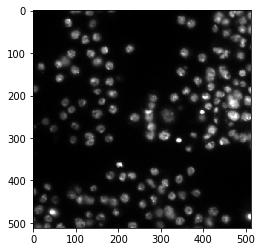

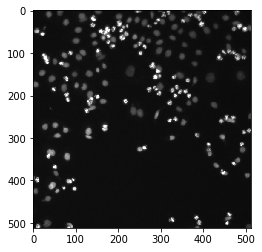

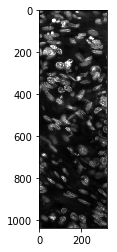

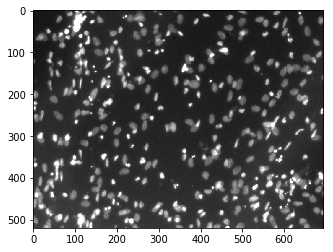

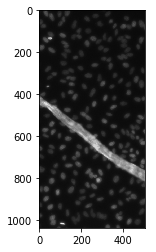

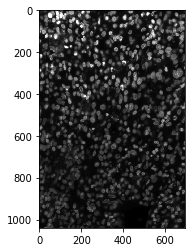

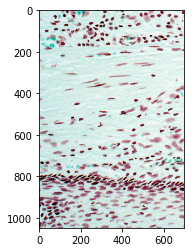

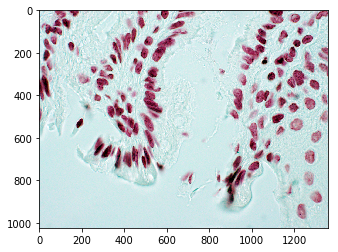

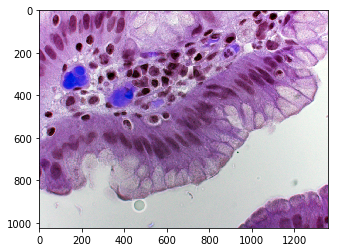

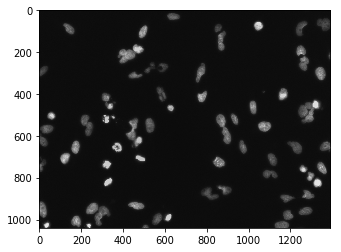

In [26]:
make_mosaic(x_test,return_connectivity=True,plot_images=True);

In [27]:
make_mosaic(x_train,return_connectivity=False,plot_images=False);

Images before filtering: (81,)
Images after filtering: (81,)


In [28]:
## This is how connectivity graph look like
make_mosaic(x_test,return_connectivity=True,plot_images=False);

Images before filtering: (10,)
Images after filtering: (10,)
{1: [43, 1, 3, 33], 2: [55, 29, 2, 41], 4: [60, 28, 4, 54], 6: [52, 62, 6, 10], 12: [36, 14, 12, 63], 13: [13, 17, 56, 47], 16: [35, 21, 16, 34], 24: [24, 49, 58, 27], 25: [26, 40, 25, 64], 30: [50, 48, 30, 32]}


In [29]:
# code which makes csv with clusters and mosaic ids for test data
imgs, data_frame = make_mosaic(x_test,return_connectivity=False,plot_images=False,external_df=test_df);
data_frame[['img_id','HSV_CLUSTER','mosaic_idx','mosaic_position']].head(20)

/home/jun/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


Images before filtering: (10,)
Images after filtering: (10,)


,img_id,HSV_CLUSTER,mosaic_idx,mosaic_position
0,0ed3555a4bd48046d3b63d8baf03a5aa97e523aa483aaa...,0,10,NaN
1,550450e4bff4036fd671decdc5d42fec23578198d6a2fd...,0,0,up_right
2,4be73d68f433869188fe5e7f09c7f681ed51003da6aa5d...,0,1,down_left
3,78a981bd27ba0c65a9169548665a17bda9f49050d0d389...,0,0,down_left
4,699f2992cd71e2e28cf45f81347ff22e76b37541ce8808...,0,2,down_left
5,51c70bb8a299943b27f8b354571272692d8f2705036a1a...,0,11,NaN
6,0999dab07b11bc85fb8464fc36c947fbd8b5d6ec498173...,0,3,down_left
7,4f949bd8d914bbfa06f40d6a0e2b5b75c38bf53dbcbafc...,0,12,NaN
8,ab298b962a63e4be9582513aaa84a5e270adba5fd2b16a...,0,13,NaN
9,0114f484a16c152baa2d82fdd43740880a762c93f436c8...,0,14,NaN
